In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg

## Funciones de utilidad

In [2]:
def cargar_resultados(directorio_resultados):
    resultados_integrados = {}
    todos_los_resultados = os.listdir(directorio_resultados)
    for resultados in todos_los_resultados:
        with open(os.path.join(directorio_resultados, resultados), "r") as archivo:
            resultados_integrados = resultados_integrados | json.load(archivo)

    return resultados_integrados

In [3]:
def generar_tabla_resumen_resultados(resultados_grasp, resultados_ga):
    algoritmos_configuraciones = []
    lambdas = []
    instancias = []
    eficacia_media = []
    cobertura_media_roles = []
    balance_medio_generos = []
    tiempo_medio_convergencia = []
    eficacia_media_sin_busqueda_local = []
    eficacia_media_con_busqueda_local = []
    
    for valor_alfa in ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]:
        for nombre_instancia in resultados_grasp.keys():
            for valor_lambda in ["0.5", "0.8"]:
                algoritmos_configuraciones.append(f"GRASP_alfa_{valor_alfa}")
                instancias.append(nombre_instancia)
                lambdas.append(valor_lambda)
                eficacia_media.append(np.mean(resultados_grasp[nombre_instancia][valor_alfa]["first-improving"][valor_lambda]["f_mejores_soluciones"]))
                cobertura_media_roles.append(np.mean(resultados_grasp[nombre_instancia][valor_alfa]["first-improving"][valor_lambda]["cobertura_roles_mejores_soluciones"]))
                balance_medio_generos.append(np.mean(resultados_grasp[nombre_instancia][valor_alfa]["first-improving"][valor_lambda]["balance_generos_mejores_soluciones"]))
                tiempo_medio_convergencia.append(np.mean(resultados_grasp[nombre_instancia][valor_alfa]["first-improving"][valor_lambda]["tiempos_convergencia"]))
                eficacia_media_sin_busqueda_local.append(np.mean(resultados_grasp[nombre_instancia][valor_alfa]["first-improving"][valor_lambda]["f_alfa"]))
                eficacia_media_con_busqueda_local.append(np.mean(resultados_grasp[nombre_instancia][valor_alfa]["first-improving"][valor_lambda]["f_busqueda_local"]))

    for nombre_instancia in resultados_ga.keys():
        for valor_lambda in ["0.5", "0.8"]:
            algoritmos_configuraciones.append("GA")
            instancias.append(nombre_instancia)
            lambdas.append(valor_lambda)
            eficacia_media.append(np.mean(resultados_ga[nombre_instancia][valor_lambda]["fitness_mejores_soluciones"]))
            cobertura_media_roles.append(np.mean(resultados_ga[nombre_instancia][valor_lambda]["cobertura_roles_mejores_soluciones"]))
            balance_medio_generos.append(np.mean(resultados_ga[nombre_instancia][valor_lambda]["balance_generos_mejores_soluciones"]))
            tiempo_medio_convergencia.append(np.mean(resultados_ga[nombre_instancia][valor_lambda]["tiempos_convergencia"]))
            eficacia_media_sin_busqueda_local.append(np.nan)
            eficacia_media_con_busqueda_local.append(np.nan)

    datos = {
        "Alg./Config.": algoritmos_configuraciones,
        "Lambda": lambdas,
        "Instancia": instancias,
        "Eficacia media": eficacia_media,
        "Cobertura media de roles": cobertura_media_roles,
        "Balance medio de generos": balance_medio_generos,
        "Tiempo medio de convergencia (s)": tiempo_medio_convergencia,
        "Eficacia media sin busqueda local": eficacia_media_sin_busqueda_local,
        "Eficacia media con busqueda local": eficacia_media_con_busqueda_local
    }

    tabla_resumen_resultados = pd.DataFrame(datos)

    return tabla_resumen_resultados

In [4]:
def generar_grafico_de_boxplot_resultados_grasp(tabla_resumen_resultados, valor_lambda, medida):
    eficacia_media = {"40 alumnos": [], "50 alumnos": [], "60 alumnos": []}
    alfas = ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
    for valor_alfa in alfas:
        for tipos_instancias in ["40", "50", "60"]:
            aux = tabla_resumen_resultados[(tabla_resumen_resultados["Alg./Config."] == f"GRASP_alfa_{valor_alfa}") & (tabla_resumen_resultados["Lambda"] == valor_lambda) & (tabla_resumen_resultados["Instancia"].str.contains(tipos_instancias))]
            eficacia_media[tipos_instancias + " alumnos"].append(aux[medida].tolist())

    etiquetas_eje_x = alfas
    categoria_1 = eficacia_media["40 alumnos"]
    categoria_2 = eficacia_media["50 alumnos"]
    categoria_3 = eficacia_media["60 alumnos"]

    x = np.arange(len(etiquetas_eje_x))
    ancho_caja = 0.2
    fig, ax = plt.subplots(figsize=(10, 5))
    box1 = ax.boxplot(categoria_1, positions=x - ancho_caja, widths=ancho_caja, boxprops=dict(facecolor="#4169E1"), medianprops=dict(color="black", linewidth=1.5), whiskerprops=dict(color="black", linewidth=1.5), capprops=dict(color="black", linewidth=1.5), flierprops=dict(marker="o", color="red", markersize=5), showcaps=True, patch_artist=True)
    box2 = ax.boxplot(categoria_2, positions=x, widths=ancho_caja, boxprops=dict(facecolor="#FF8C00"), medianprops=dict(color="black", linewidth=1.5), whiskerprops=dict(color="black", linewidth=1.5), capprops=dict(color="black", linewidth=1.5), flierprops=dict(marker="o", color="red", markersize=5), showcaps=True, patch_artist=True)
    box3 = ax.boxplot(categoria_3, positions=x + ancho_caja, widths=ancho_caja, boxprops=dict(facecolor="#32CD32"), medianprops=dict(color="black", linewidth=1.5), whiskerprops=dict(color="black", linewidth=1.5), capprops=dict(color="black", linewidth=1.5), flierprops=dict(marker="o", color="red", markersize=5), showcaps=True, patch_artist=True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Valores del parametro $\\alpha$", fontsize=12)
    if medida != "Tiempo medio de convergencia (s)":
        if medida == "Eficacia media":
            ax.set_ylabel(f"Calidad de solucion ($\\lambda$ = {valor_lambda})", fontsize=12)
    else:
        ax.set_ylabel(f"Tiempo de convergencia (s) ($\\lambda$ = {valor_lambda})", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(etiquetas_eje_x)
    if medida != "Tiempo medio de convergencia (s)":
        ax.set_ylim(0.90, 1.0)
        ax.set_yticks(np.arange(0.90, 1.01, 0.01))
    ax.tick_params(axis="both", labelsize=12)
    blue_patch = plt.Line2D([], [], color="#4169E1", marker="s", markersize=10, label="Instancias de 40 alumnos")
    orange_patch = plt.Line2D([], [], color="#FF8C00", marker="s", markersize=10, label="Instancias de 50 alumnos")
    green_patch = plt.Line2D([], [], color="#32CD32", marker="s", markersize=10, label="Instancias de 60 alumnos")
    ax.legend(handles=[blue_patch, orange_patch, green_patch], fontsize=10)
    plt.tight_layout()
    #plt.savefig("C:/Users/dylan/OneDrive - UPV/Ciencia de Datos/4 Curso/Cuatrimestre B/Trabajo Fin de Grado/Memoria/Figuras/Figura 27.png", bbox_inches="tight")
    plt.show()

In [5]:
def min_max_cobertura_roles_balance_generos_grasp(tabla_resumen_resultados):
    cobertura_media_roles = {"40 alumnos": [], "50 alumnos": [], "60 alumnos": []}
    balance_medio_generos = {"40 alumnos": [], "50 alumnos": [], "60 alumnos": []}
    for tipos_instancias in ["40", "50", "60"]:
        aux = tabla_resumen_resultados[(tabla_resumen_resultados["Alg./Config."].str.contains("GRASP")) & (tabla_resumen_resultados["Instancia"].str.contains(tipos_instancias))]
        min_cobertura_media_roles = min(aux["Cobertura media de roles"])
        max_cobertura_media_roles = max(aux["Cobertura media de roles"])
        min_balance_medio_generos = min(aux["Balance medio de generos"])
        max_balance_medio_generos = max(aux["Balance medio de generos"])
        print(f"El valor de la cobertura de roles de los equipos creados para las instancias de {tipos_instancias} alumnos oscila dentro del intervalo [{min_cobertura_media_roles},{max_cobertura_media_roles}], mientras que el balance de generos oscila alrededor de [{min_balance_medio_generos},{max_balance_medio_generos}]")

In [6]:
def generar_grafico_de_lineas_resultados_grasp(tabla_resumen_resultados, valor_lambda):
    eficacia_media_40_alumnos = {}
    eficacia_media_50_alumnos = {}
    eficacia_media_60_alumnos = {}
    alfas = ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
    for valor_alfa in alfas:
        for tipos_instancias in ["40", "50", "60"]:
            aux = tabla_resumen_resultados[(tabla_resumen_resultados["Alg./Config."] == f"GRASP_alfa_{valor_alfa}") & (tabla_resumen_resultados["Lambda"] == valor_lambda) & (tabla_resumen_resultados["Instancia"].str.contains(tipos_instancias))]
            if tipos_instancias == "40":
                eficacia_media_40_alumnos[valor_alfa] = (np.mean(aux["Eficacia media sin busqueda local"]), np.mean(aux["Eficacia media con busqueda local"]))
            elif tipos_instancias == "50":
                eficacia_media_50_alumnos[valor_alfa] = (np.mean(aux["Eficacia media sin busqueda local"]), np.mean(aux["Eficacia media con busqueda local"]))
            elif tipos_instancias == "60":
                eficacia_media_60_alumnos[valor_alfa] = (np.mean(aux["Eficacia media sin busqueda local"]), np.mean(aux["Eficacia media con busqueda local"]))

    etiquetas_eje_x = alfas
    x = np.arange(len(etiquetas_eje_x))
    fig, axs = plt.subplots(1, 3, figsize=(20, 7.5))
    for i, tipos_instancias in enumerate(["40", "50", "60"]):
        if i == 0:
            categoria_1 = [j[0] for j in eficacia_media_40_alumnos.values()]
            categoria_2 = [j[1] for j in eficacia_media_40_alumnos.values()]
        elif i == 1:
            categoria_1 = [j[0] for j in eficacia_media_50_alumnos.values()]
            categoria_2 = [j[1] for j in eficacia_media_50_alumnos.values()]
        elif i == 2:
            categoria_1 = [j[0] for j in eficacia_media_60_alumnos.values()]
            categoria_2 = [j[1] for j in eficacia_media_60_alumnos.values()]
        axs[i].plot(etiquetas_eje_x, categoria_1, color="#4169E1", label="Sin busqueda local")
        axs[i].plot(etiquetas_eje_x, categoria_2, color="#FF8C00", label="Con busqueda local")
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
        axs[i].set_title(f"Instancias de {tipos_instancias} alumnos", fontsize=12)
        axs[i].set_xlabel("Valores del parametro $\\alpha$", fontsize=12)
        axs[i].set_ylabel(f"Calidad media de solucion ($\\lambda$ = {valor_lambda})", fontsize=12)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(etiquetas_eje_x)
        axs[i].set_ylim(0.84, 1.0)
        axs[i].set_yticks(np.arange(0.84, 1.0, 0.02))
        axs[i].tick_params(axis="both", labelsize=12)
        axs[i].legend(fontsize=10)
    plt.subplots_adjust(wspace=0.3)
    #plt.savefig("C:/Users/dylan/OneDrive - UPV/Ciencia de Datos/4 Curso/Cuatrimestre B/Trabajo Fin de Grado/Memoria/Figuras/Figura 26.png", bbox_inches="tight")
    plt.show()

In [7]:
def generar_grafico_de_boxplot_resultados_algoritmos(tabla_resumen_resultados):
    eficacia_media_lambda_0_5 = {"GRASP_alfa_0.0": [], "GA": []}
    eficacia_media_lambda_0_8 = {"GRASP_alfa_0.0": [], "GA": []}
    for algoritmo in ["GRASP_alfa_0.0", "GA"]:
        for valor_lambda in ["0.5", "0.8"]:
            for tipos_instancias in ["40", "50", "60"]:
                aux = tabla_resumen_resultados[(tabla_resumen_resultados["Alg./Config."] == algoritmo) & (tabla_resumen_resultados["Lambda"] == valor_lambda) & (tabla_resumen_resultados["Instancia"].str.contains(tipos_instancias))]
                if valor_lambda == "0.5":
                    eficacia_media_lambda_0_5[algoritmo].append(aux["Eficacia media"].tolist())
                elif valor_lambda == "0.8":
                    eficacia_media_lambda_0_8[algoritmo].append(aux["Eficacia media"].tolist())

    etiquetas_eje_x = ["40 alumnos", "50 alumnos", "60 alumnos"]
    x = np.arange(len(etiquetas_eje_x))
    ancho_caja = 0.2
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for i in range(2):
        if i == 0:
            valor_lambda = "0.5"
            categoria_1 = eficacia_media_lambda_0_5["GRASP_alfa_0.0"]
            categoria_2 = eficacia_media_lambda_0_5["GA"]
        elif i == 1:
            valor_lambda = "0.8"
            categoria_1 = eficacia_media_lambda_0_8["GRASP_alfa_0.0"]
            categoria_2 = eficacia_media_lambda_0_8["GA"]
        axs[i].boxplot(categoria_1, positions=x - ancho_caja/2, widths=ancho_caja, boxprops=dict(facecolor="#4169E1"), medianprops=dict(color="black", linewidth=1.5), whiskerprops=dict(color="black", linewidth=1.5), capprops=dict(color="black", linewidth=1.5), flierprops=dict(marker="o", color="red", markersize=5), showcaps=True, patch_artist=True)
        axs[i].boxplot(categoria_2, positions=x + ancho_caja/2, widths=ancho_caja, boxprops=dict(facecolor="#FF8C00"), medianprops=dict(color="black", linewidth=1.5), whiskerprops=dict(color="black", linewidth=1.5), capprops=dict(color="black", linewidth=1.5), flierprops=dict(marker="o", color="red", markersize=5), showcaps=True, patch_artist=True)
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
        axs[i].set_xlabel("Tipos de instancias", fontsize=12)
        axs[i].set_ylabel(f"Calidad de solucion ($\\lambda$ = {valor_lambda})", fontsize=12)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(etiquetas_eje_x)
        axs[i].set_ylim(0.90, 1.0)
        axs[i].set_yticks(np.arange(0.90, 1.01, 0.01))
        axs[i].tick_params(axis="both", labelsize=12)
        blue_patch = plt.Line2D([], [], color="#4169E1", marker="s", markersize=10, label="GRASP ($\\alpha$=0.0)")
        orange_patch = plt.Line2D([], [], color="#FF8C00", marker="s", markersize=10, label="GA")
        axs[i].legend(handles=[blue_patch, orange_patch], fontsize=10)
    plt.subplots_adjust(wspace=0.3)
    #plt.savefig("C:/Users/dylan/OneDrive - UPV/Ciencia de Datos/4 Curso/Cuatrimestre B/Trabajo Fin de Grado/Memoria/Figuras/Figura 28.png", bbox_inches="tight")
    plt.show()

In [8]:
def generar_grafico_de_boxplot_resultados_algoritmos_v2(tabla_resumen_resultados, valor_lambda):
    tiempo_medio_convergencia = {"GRASP_alfa_0.0": [], "GA": []}
    for algoritmo in ["GRASP_alfa_0.0", "GA"]:
        for tipos_instancias in ["40", "50", "60"]:
            aux = tabla_resumen_resultados[(tabla_resumen_resultados["Alg./Config."] == algoritmo) & (tabla_resumen_resultados["Lambda"] == valor_lambda) & (tabla_resumen_resultados["Instancia"].str.contains(tipos_instancias))]
            tiempo_medio_convergencia[algoritmo].append(aux["Tiempo medio de convergencia (s)"].tolist())

    etiquetas_eje_x = ["40 alumnos", "50 alumnos", "60 alumnos"]
    categoria_1 = tiempo_medio_convergencia["GRASP_alfa_0.0"]
    categoria_2 = tiempo_medio_convergencia["GA"]

    x = np.arange(len(etiquetas_eje_x))
    ancho_caja = 0.2
    fig, ax = plt.subplots(figsize=(15, 5))
    box1 = ax.boxplot(categoria_1, positions=x - ancho_caja/2, widths=ancho_caja, boxprops=dict(facecolor="#4169E1"), medianprops=dict(color="black", linewidth=1.5), whiskerprops=dict(color="black", linewidth=1.5), capprops=dict(color="black", linewidth=1.5), flierprops=dict(marker="o", color="red", markersize=5), showcaps=True, patch_artist=True)
    box2 = ax.boxplot(categoria_2, positions=x + ancho_caja/2, widths=ancho_caja, boxprops=dict(facecolor="#FF8C00"), medianprops=dict(color="black", linewidth=1.5), whiskerprops=dict(color="black", linewidth=1.5), capprops=dict(color="black", linewidth=1.5), flierprops=dict(marker="o", color="red", markersize=5), showcaps=True, patch_artist=True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Tipos de instancias", fontsize=12)
    ax.set_ylabel(f"Tiempo de convergencia (s) ($\\lambda$ = {valor_lambda})", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(etiquetas_eje_x)
    ax.tick_params(axis="both", labelsize=12)
    blue_patch = plt.Line2D([], [], color="#4169E1", marker="s", markersize=10, label="GRASP ($\\alpha$=0.0)")
    orange_patch = plt.Line2D([], [], color="#FF8C00", marker="s", markersize=10, label="GA")
    ax.legend(handles=[blue_patch, orange_patch], fontsize=10)
    plt.tight_layout()
    #plt.savefig("C:/Users/dylan/OneDrive - UPV/Ciencia de Datos/4 Curso/Cuatrimestre B/Trabajo Fin de Grado/Memoria/Figuras/Figura 29.png", bbox_inches="tight")
    plt.show()

In [9]:
def pruebas_de_normalidad(tabla_resumen_resultados, valor_lambda):
    tiempo_medio_convergencia_GRASP = {}
    tiempo_medio_convergencia_GA = {}
    for algoritmo in ["GRASP_alfa_0.0", "GA"]:
        for tipos_instancias in ["40", "50", "60"]:
            aux = tabla_resumen_resultados[(tabla_resumen_resultados["Alg./Config."] == algoritmo) & (tabla_resumen_resultados["Lambda"] == valor_lambda) & (tabla_resumen_resultados["Instancia"].str.contains(tipos_instancias))]
            if algoritmo == "GRASP_alfa_0.0":
                tiempo_medio_convergencia_GRASP[f"{tipos_instancias} alumnos"] = aux["Tiempo medio de convergencia (s)"].tolist()
            elif algoritmo == "GA":
                tiempo_medio_convergencia_GA[f"{tipos_instancias} alumnos"] = aux["Tiempo medio de convergencia (s)"].tolist()

    fig, axs = plt.subplots(2, 3, figsize=(20, 7.5))
    for i, algoritmo in enumerate(["GRASP", "GA"]):
        for j, tipo_instancias in enumerate(["40 alumnos", "50 alumnos", "60 alumnos"]):
            if algoritmo == "GRASP":
                titulo = "GRASP ($\\alpha$=0.0)"
                muestra = tiempo_medio_convergencia_GRASP[tipo_instancias]
            elif algoritmo == "GA":
                titulo = "GA"
                muestra = tiempo_medio_convergencia_GA[tipo_instancias]
            p_valor_shapiro = round(pg.normality(muestra, method="shapiro")["pval"].values[0], 3)
            stats.probplot(muestra, dist="norm", plot=axs[i, j])
            axs[i, j].spines["top"].set_visible(False)
            axs[i, j].spines["right"].set_visible(False)
            axs[i, j].set_title(f"{titulo}, instancias de {tipo_instancias}", fontsize=12)
            axs[i, j].set_xlabel("Cuartiles teóricos", fontsize=12)
            axs[i, j].set_ylabel("Cuartiles de la muestra", fontsize=12)
            axs[i, j].tick_params(axis="both", labelsize=12)
            axs[i, j].text(0.05, 0.95, f"p-valor Shapiro-Wilk: {p_valor_shapiro}",
                           transform=axs[i, j].transAxes, fontsize=10, 
                           verticalalignment="top", horizontalalignment="left")
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    #plt.savefig("C:/Users/dylan/OneDrive - UPV/Ciencia de Datos/4 Curso/Cuatrimestre B/Trabajo Fin de Grado/Memoria/Figuras/Figura 30.png", bbox_inches="tight")
    plt.show

In [10]:
def pruebas_de_significancia(tabla_resumen_resultados, valor_lambda):
    tiempo_medio_convergencia_GRASP = {}
    tiempo_medio_convergencia_GA = {}
    for algoritmo in ["GRASP_alfa_0.0", "GA"]:
        for tipos_instancias in ["40", "50", "60"]:
            aux = tabla_resumen_resultados[(tabla_resumen_resultados["Alg./Config."] == algoritmo) & (tabla_resumen_resultados["Lambda"] == valor_lambda) & (tabla_resumen_resultados["Instancia"].str.contains(tipos_instancias))]
            if algoritmo == "GRASP_alfa_0.0":
                tiempo_medio_convergencia_GRASP[f"{tipos_instancias} alumnos"] = aux["Tiempo medio de convergencia (s)"].tolist()
            elif algoritmo == "GA":
                tiempo_medio_convergencia_GA[f"{tipos_instancias} alumnos"] = aux["Tiempo medio de convergencia (s)"].tolist()

    for tipos_instancias in ["40 alumnos", "50 alumnos", "60 alumnos"]:
        muestra_1 = tiempo_medio_convergencia_GRASP[tipos_instancias]
        muestra_2 = tiempo_medio_convergencia_GA[tipos_instancias]
        if tipos_instancias != "50 alumnos":
            p_valor = pg.wilcoxon(muestra_1, muestra_2, alternative="less")["p-val"].values[0]
        else:
            p_valor = pg.ttest(muestra_1, muestra_2, paired=True, alternative="less")["p-val"].values[0]
        if p_valor > 0.05:
            print(f"El tiempo medio de convergencia de GRASP para las instancias de {tipos_instancias} no es significativamente menor que el del algoritmo genetico (p-valor={p_valor})")
        else:
            print(f"El tiempo de convergencia de GRASP para las instancias de {tipos_instancias} es, en promedio, significativamente menor que el del algoritmo genetico (p-valor={p_valor})")

## Tabla resumen resultados

In [11]:
resultados_grasp = cargar_resultados("./archivos_resultados_experimentacion/GRASP")
resultados_ga = cargar_resultados("./archivos_resultados_experimentacion/GA")
tabla_resumen_resultados = generar_tabla_resumen_resultados(resultados_grasp, resultados_ga)
tabla_resumen_resultados

,Alg./Config.,Lambda,Instancia,Eficacia media,Cobertura media de roles,Balance medio de generos,Tiempo medio de convergencia (s),Eficacia media sin busqueda local,Eficacia media con busqueda local
0,GRASP_alfa_0.0,0.5,instancia_40_5 (1),0.929688,0.953125,0.906250,0.804342,0.918974,0.929638
1,GRASP_alfa_0.0,0.8,instancia_40_5 (1),0.943750,0.953125,0.906250,0.954695,0.926115,0.943750
2,GRASP_alfa_0.0,0.5,instancia_40_5 (10),0.953125,1.000000,0.906250,0.676784,0.951911,0.953125
3,GRASP_alfa_0.0,0.8,instancia_40_5 (10),0.981250,1.000000,0.906250,0.787306,0.962143,0.981250
4,GRASP_alfa_0.0,0.5,instancia_40_5 (2),0.950000,1.000000,0.900000,0.832596,0.939194,0.950000
...,...,...,...,...,...,...,...,...,...
715,GA,0.8,instancia_60_5 (7),0.985000,1.000000,0.925000,34.101417,NaN,NaN
716,GA,0.5,instancia_60_5 (8),0.974306,0.979167,0.969444,26.856286,NaN,NaN
717,GA,0.8,instancia_60_5 (8),0.977222,0.979167,0.969444,24.091802,NaN,NaN
718,GA,0.5,instancia_60_5 (9),0.969097,0.968750,0.969444,25.127392,NaN,NaN


## Resultados de GRASP

**Figura 24**

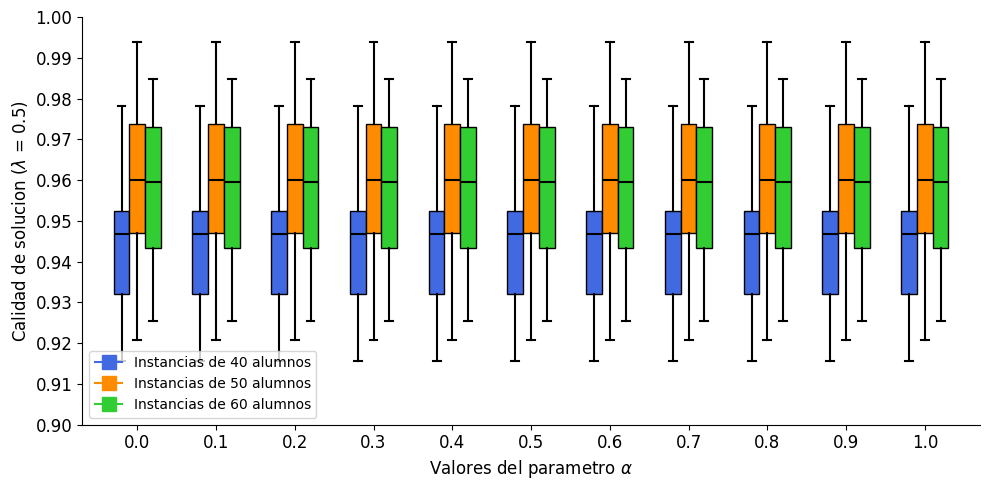

In [12]:
generar_grafico_de_boxplot_resultados_grasp(tabla_resumen_resultados, valor_lambda="0.5", medida="Eficacia media")

**Figura 25**

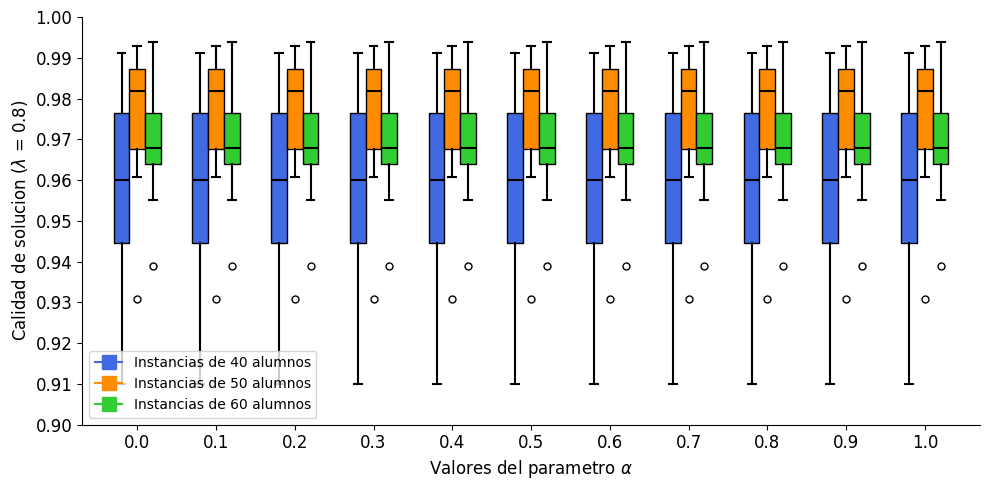

In [13]:
generar_grafico_de_boxplot_resultados_grasp(tabla_resumen_resultados, valor_lambda="0.8", medida="Eficacia media")

In [14]:
min_max_cobertura_roles_balance_generos_grasp(tabla_resumen_resultados)

El valor de la cobertura de roles de los equipos creados para las instancias de 40 alumnos oscila dentro del intervalo [0.90625,1.0], mientras que el balance de generos oscila alrededor de [0.9,0.9562500000000002]
El valor de la cobertura de roles de los equipos creados para las instancias de 50 alumnos oscila dentro del intervalo [0.9375,1.0], mientras que el balance de generos oscila alrededor de [0.9039999999999999,1.0]
El valor de la cobertura de roles de los equipos creados para las instancias de 60 alumnos oscila dentro del intervalo [0.9479166666666666,1.0], mientras que el balance de generos oscila alrededor de [0.9,1.0]


**Figura 26**

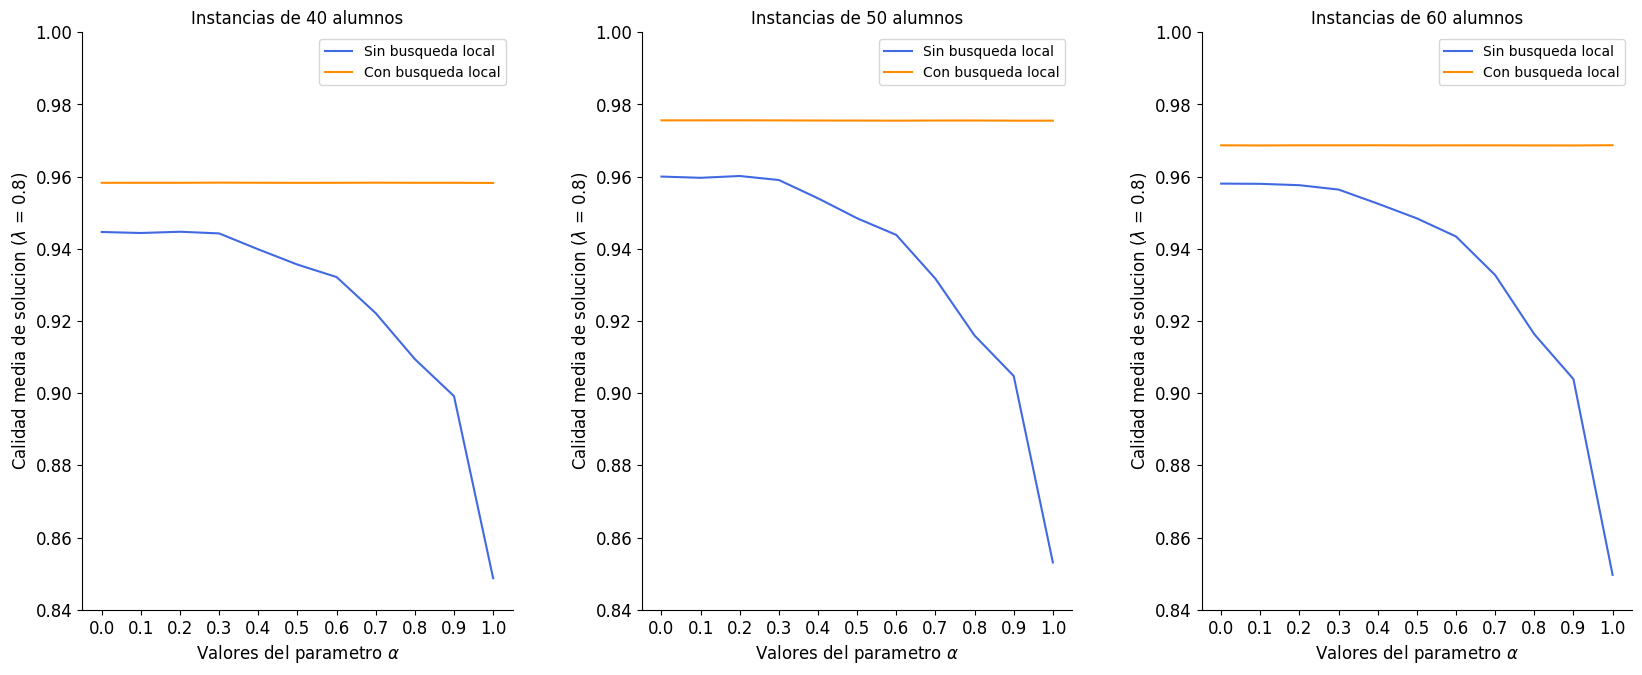

In [15]:
generar_grafico_de_lineas_resultados_grasp(tabla_resumen_resultados, valor_lambda="0.8")

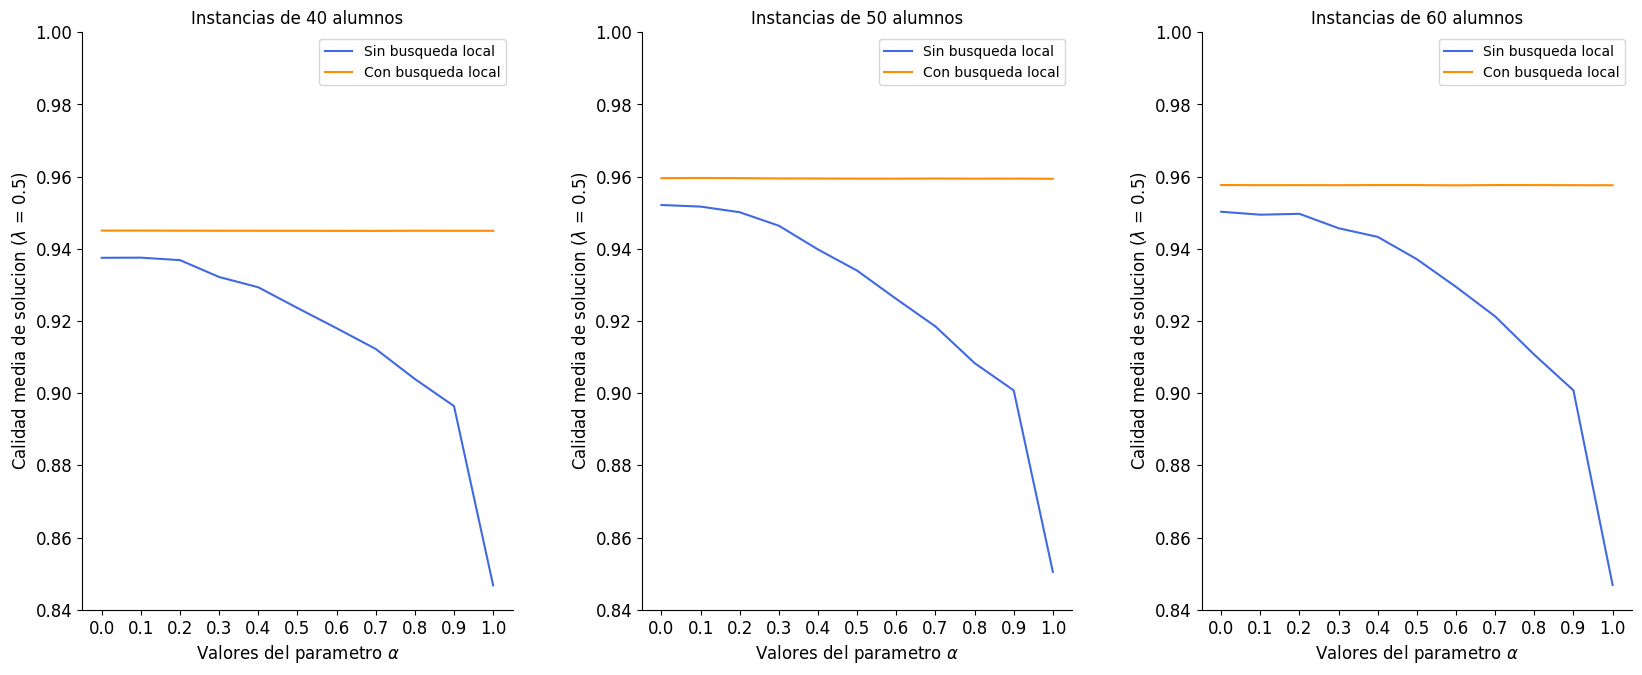

In [16]:
generar_grafico_de_lineas_resultados_grasp(tabla_resumen_resultados, valor_lambda="0.5")

**Figura 27**

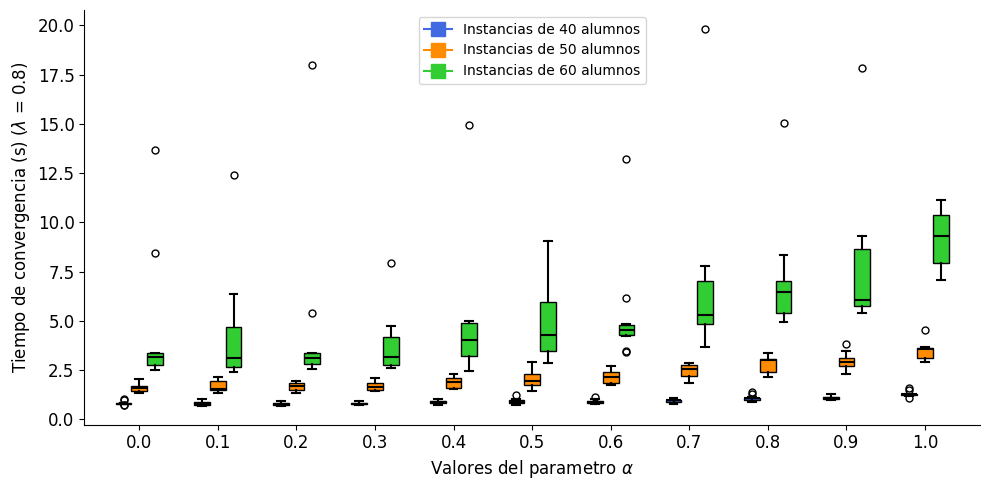

In [17]:
generar_grafico_de_boxplot_resultados_grasp(tabla_resumen_resultados, valor_lambda="0.8", medida="Tiempo medio de convergencia (s)")

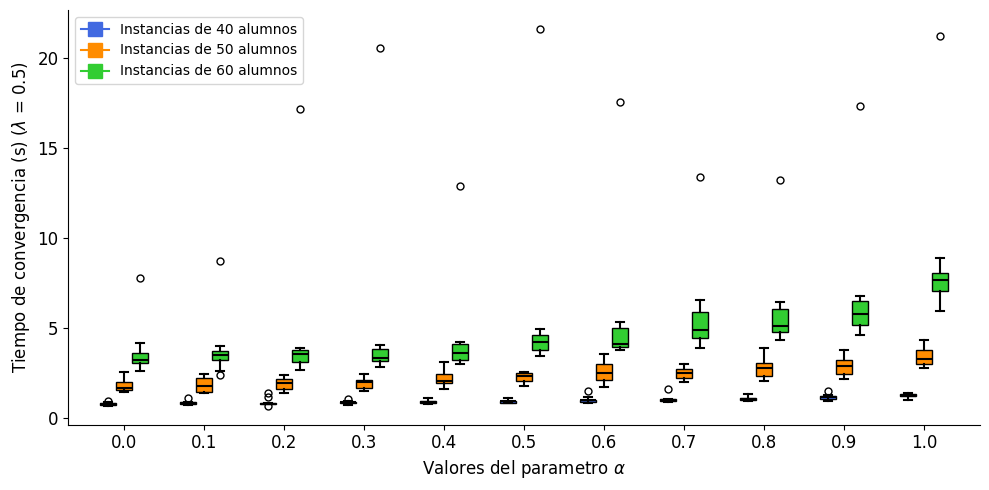

In [18]:
generar_grafico_de_boxplot_resultados_grasp(tabla_resumen_resultados, valor_lambda="0.5", medida="Tiempo medio de convergencia (s)")

## Comparacion entre GRASP y el algoritmo genetico

**Figura 28**

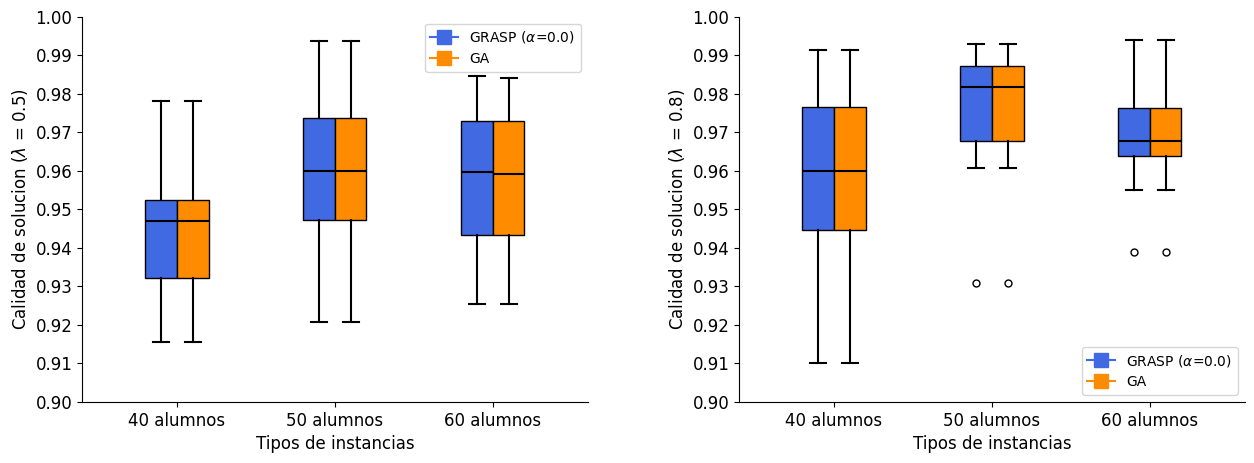

In [19]:
generar_grafico_de_boxplot_resultados_algoritmos(tabla_resumen_resultados)

**Figura 29**

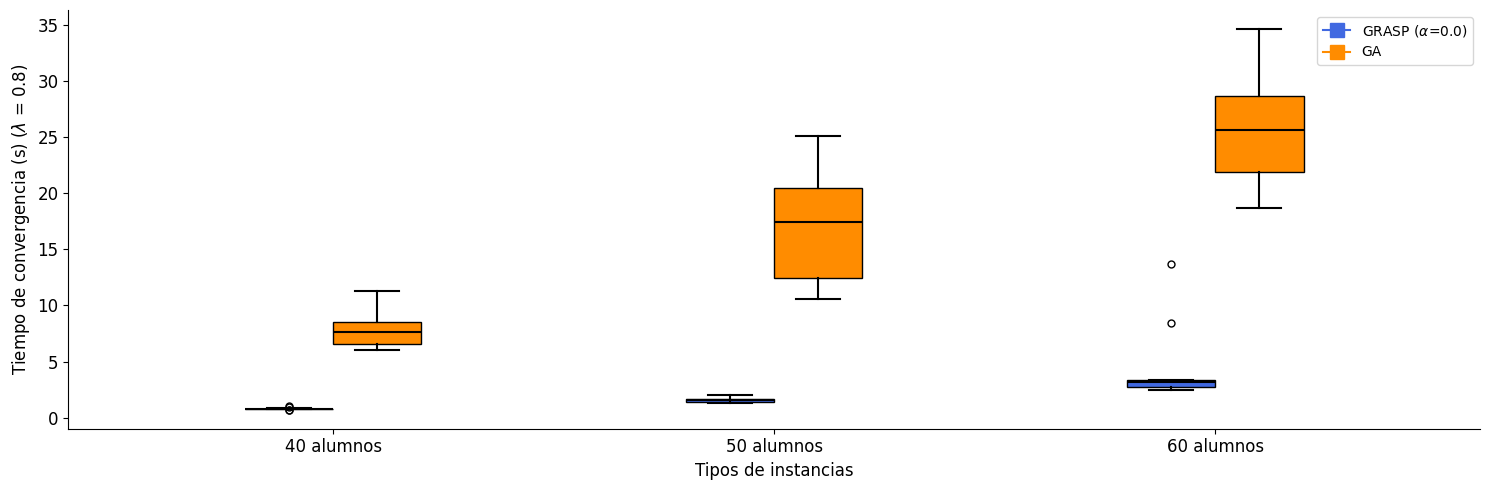

In [20]:
generar_grafico_de_boxplot_resultados_algoritmos_v2(tabla_resumen_resultados, valor_lambda="0.8")

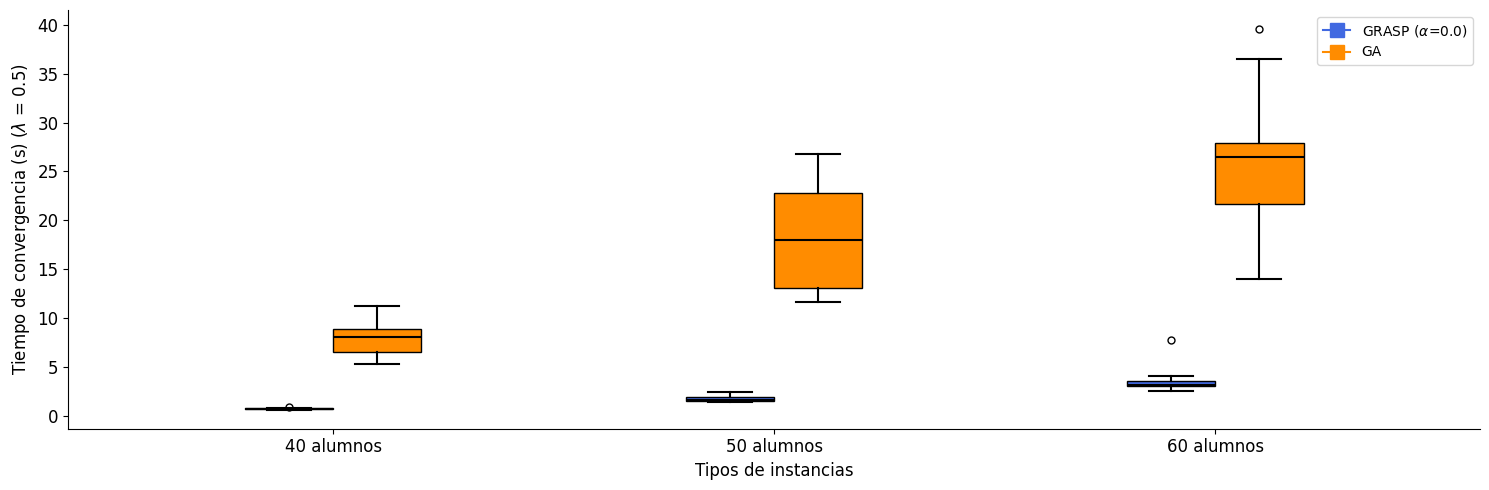

In [21]:
generar_grafico_de_boxplot_resultados_algoritmos_v2(tabla_resumen_resultados, valor_lambda="0.5")

**Figura 30**

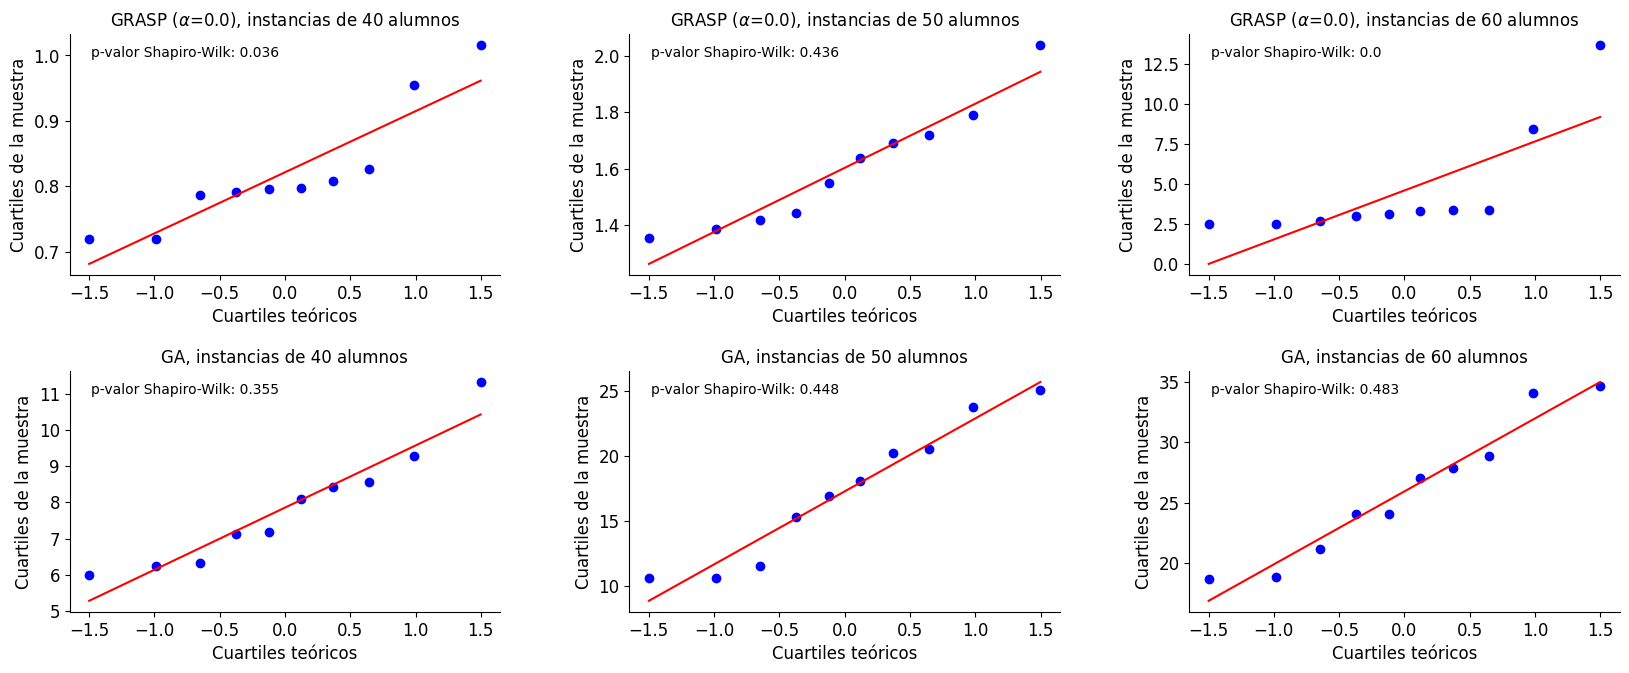

In [22]:
pruebas_de_normalidad(tabla_resumen_resultados, valor_lambda="0.8")

In [23]:
pruebas_de_significancia(tabla_resumen_resultados, valor_lambda="0.8")

El tiempo de convergencia de GRASP para las instancias de 40 alumnos es, en promedio, significativamente menor que el del algoritmo genetico (p-valor=0.0009765625)
El tiempo de convergencia de GRASP para las instancias de 50 alumnos es, en promedio, significativamente menor que el del algoritmo genetico (p-valor=2.3915134442839483e-06)
El tiempo de convergencia de GRASP para las instancias de 60 alumnos es, en promedio, significativamente menor que el del algoritmo genetico (p-valor=0.0009765625)
